In [31]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [32]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [33]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

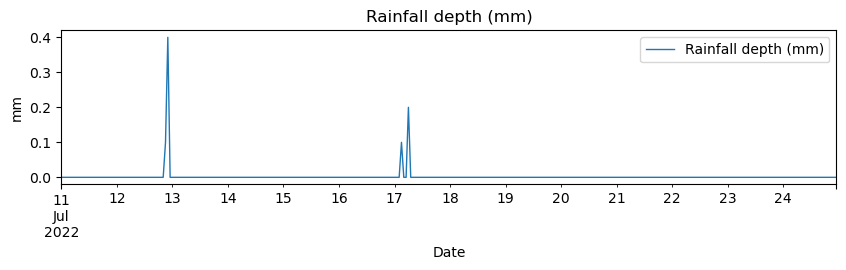

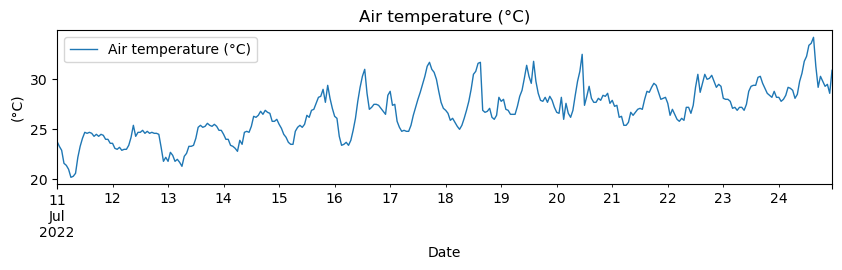

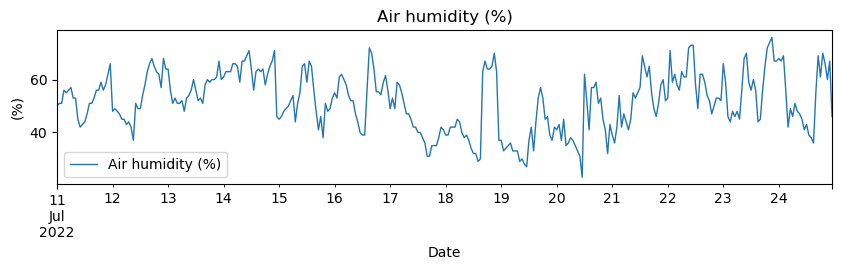

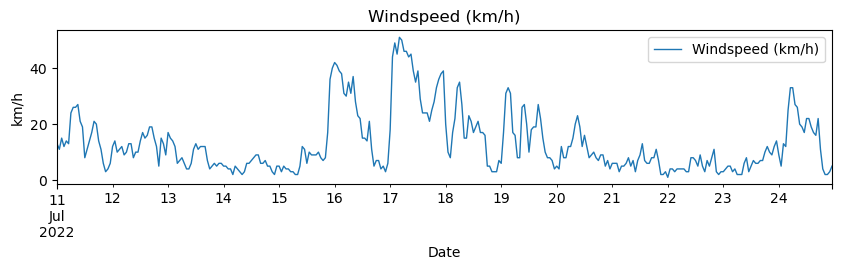

In [34]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-07-11'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73435D+00    |proj g|=  7.92243D-02


 This problem is unconstrained.



At iterate    5    f=  1.72502D+00    |proj g|=  1.61592D-01

At iterate   10    f=  1.71799D+00    |proj g|=  3.48391D-02

At iterate   15    f=  1.71739D+00    |proj g|=  8.07245D-02

At iterate   20    f=  1.71714D+00    |proj g|=  1.31674D-02

At iterate   25    f=  1.71696D+00    |proj g|=  8.50735D-03

At iterate   30    f=  1.71695D+00    |proj g|=  2.16316D-03

At iterate   35    f=  1.71684D+00    |proj g|=  1.43525D-02

At iterate   40    f=  1.71666D+00    |proj g|=  4.05540D-03

At iterate   45    f=  1.71665D+00    |proj g|=  1.75902D-03

At iterate   50    f=  1.71665D+00    |proj g|=  4.17129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

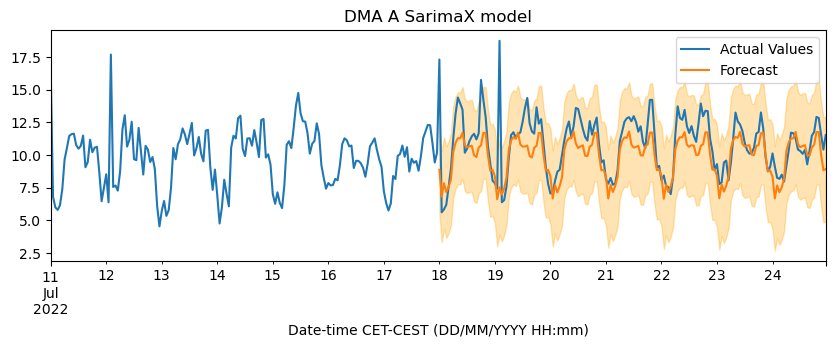

Performance indicators
DMA A Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.71            8.44             1.16           11.30 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.74            7.56             1.98           12.28 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71715D-01    |proj g|=  6.96592D-01


 This problem is unconstrained.



At iterate    5    f=  8.23559D-01    |proj g|=  4.75545D-01

At iterate   10    f=  7.94669D-01    |proj g|=  4.03125D-01

At iterate   15    f=  7.92566D-01    |proj g|=  6.01662D-02

At iterate   20    f=  7.91797D-01    |proj g|=  4.82553D-02

At iterate   25    f=  7.90587D-01    |proj g|=  4.50161D-02

At iterate   30    f=  7.89938D-01    |proj g|=  6.45927D-02

At iterate   35    f=  7.89481D-01    |proj g|=  4.48790D-02

At iterate   40    f=  7.89220D-01    |proj g|=  2.77761D-02

At iterate   45    f=  7.80700D-01    |proj g|=  5.37791D-02

At iterate   50    f=  7.75586D-01    |proj g|=  4.27620D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

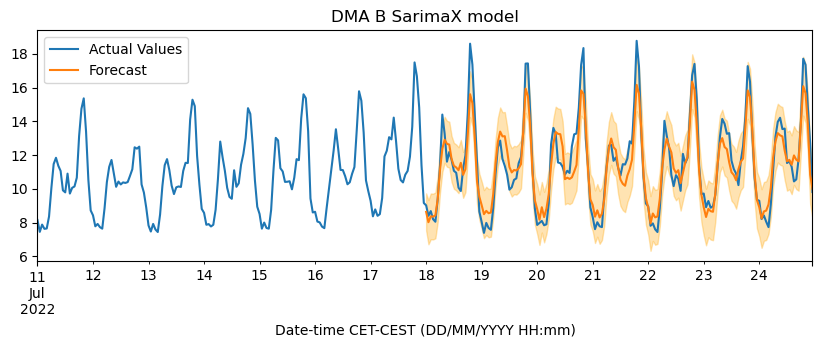

Performance indicators
DMA B Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.84            2.99             0.76           4.60 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.16            7.90             2.17           12.22 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93976D-01    |proj g|=  5.80459D-01


 This problem is unconstrained.



At iterate    5    f=  7.57217D-01    |proj g|=  3.03394D-01

At iterate   10    f=  7.20368D-01    |proj g|=  3.66575D-01

At iterate   15    f=  7.12505D-01    |proj g|=  2.42791D-01

At iterate   20    f=  7.10976D-01    |proj g|=  1.65441D-01

At iterate   25    f=  7.03683D-01    |proj g|=  9.39758D-02

At iterate   30    f=  6.95680D-01    |proj g|=  2.78273D-01

At iterate   35    f=  6.88787D-01    |proj g|=  1.07182D-02

At iterate   40    f=  6.88765D-01    |proj g|=  1.80915D-03

At iterate   45    f=  6.88718D-01    |proj g|=  2.58327D-02

At iterate   50    f=  6.88705D-01    |proj g|=  2.15061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

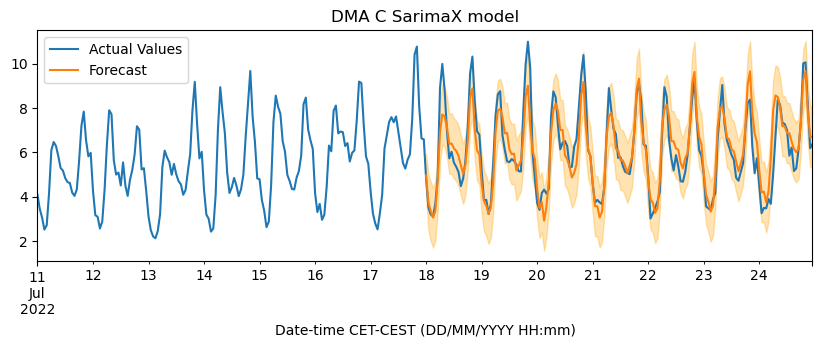

Performance indicators
DMA C Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.72            2.28             0.57           3.58 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.74            4.83             1.50           8.07 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31901D+00    |proj g|=  2.55437D-01


 This problem is unconstrained.



At iterate    5    f=  2.23327D+00    |proj g|=  4.48416D-02

At iterate   10    f=  2.21701D+00    |proj g|=  2.62344D-02

At iterate   15    f=  2.21594D+00    |proj g|=  1.98638D-02

At iterate   20    f=  2.21255D+00    |proj g|=  1.94977D-02

At iterate   25    f=  2.21101D+00    |proj g|=  3.08917D-02

At iterate   30    f=  2.21059D+00    |proj g|=  1.84782D-03

At iterate   35    f=  2.21057D+00    |proj g|=  8.21746D-03

At iterate   40    f=  2.21049D+00    |proj g|=  3.55390D-03

At iterate   45    f=  2.21036D+00    |proj g|=  3.31292D-02

At iterate   50    f=  2.20954D+00    |proj g|=  2.85107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

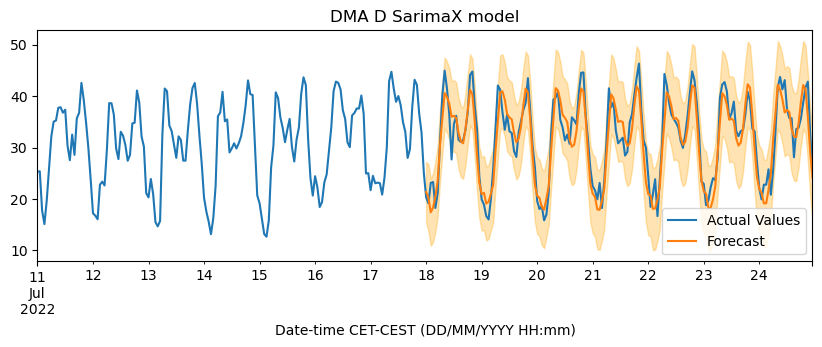

Performance indicators
DMA D Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.52            8.30             2.57           13.39 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.97            14.29             6.85           28.11 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81098D+00    |proj g|=  1.40176D-01


 This problem is unconstrained.



At iterate    5    f=  1.78911D+00    |proj g|=  4.32605D-02

At iterate   10    f=  1.78502D+00    |proj g|=  2.35764D-02

At iterate   15    f=  1.78455D+00    |proj g|=  8.62448D-03

At iterate   20    f=  1.78411D+00    |proj g|=  1.40571D-02

At iterate   25    f=  1.78390D+00    |proj g|=  3.84471D-03

At iterate   30    f=  1.78367D+00    |proj g|=  1.17972D-02

At iterate   35    f=  1.78249D+00    |proj g|=  1.63686D-02

At iterate   40    f=  1.78160D+00    |proj g|=  2.01110D-02

At iterate   45    f=  1.77733D+00    |proj g|=  1.34932D-02

At iterate   50    f=  1.77667D+00    |proj g|=  5.64940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

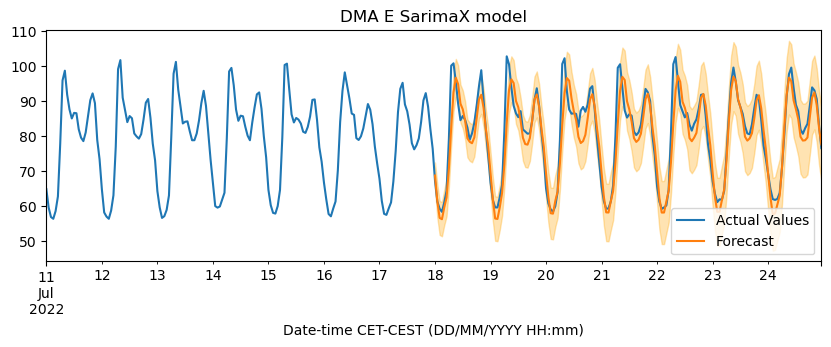

Performance indicators
DMA E Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.67            17.71             3.17           24.55 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
10.98            21.78             10.71           43.47 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51756D+00    |proj g|=  1.81156D-01


 This problem is unconstrained.



At iterate    5    f=  1.46691D+00    |proj g|=  7.11863D-01

At iterate   10    f=  1.44040D+00    |proj g|=  1.24913D-01

At iterate   15    f=  1.43153D+00    |proj g|=  7.01999D-02

At iterate   20    f=  1.42954D+00    |proj g|=  4.46991D-02

At iterate   25    f=  1.42661D+00    |proj g|=  6.68201D-02

At iterate   30    f=  1.42577D+00    |proj g|=  5.18630D-02

At iterate   35    f=  1.42573D+00    |proj g|=  9.95063D-03

At iterate   40    f=  1.42252D+00    |proj g|=  1.50174D-01

At iterate   45    f=  1.41981D+00    |proj g|=  6.30586D-02

At iterate   50    f=  1.41743D+00    |proj g|=  1.31390D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

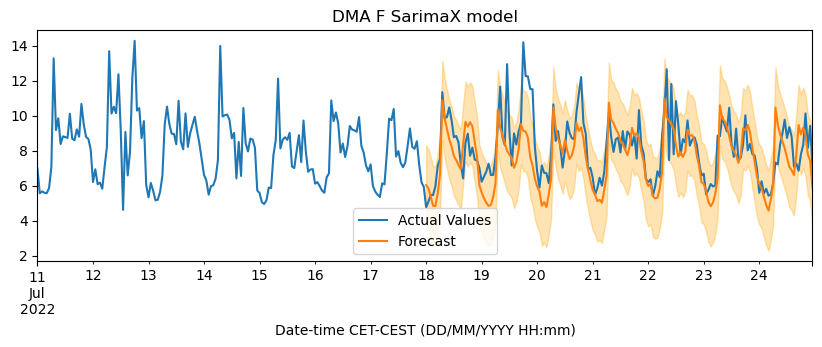

Performance indicators
DMA F Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.99            1.95             1.10           4.04 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.43            3.30             1.38           6.10 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46655D+00    |proj g|=  3.73321D-01


 This problem is unconstrained.



At iterate    5    f=  1.44842D+00    |proj g|=  8.88863D-02

At iterate   10    f=  1.44260D+00    |proj g|=  4.58324D-02

At iterate   15    f=  1.44161D+00    |proj g|=  2.40786D-02

At iterate   20    f=  1.44135D+00    |proj g|=  5.89459D-03

At iterate   25    f=  1.44103D+00    |proj g|=  2.46172D-02

At iterate   30    f=  1.44085D+00    |proj g|=  2.87499D-03

At iterate   35    f=  1.44077D+00    |proj g|=  1.66026D-02

At iterate   40    f=  1.44052D+00    |proj g|=  1.32681D-02

At iterate   45    f=  1.44046D+00    |proj g|=  4.28057D-03

At iterate   50    f=  1.44037D+00    |proj g|=  7.78982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

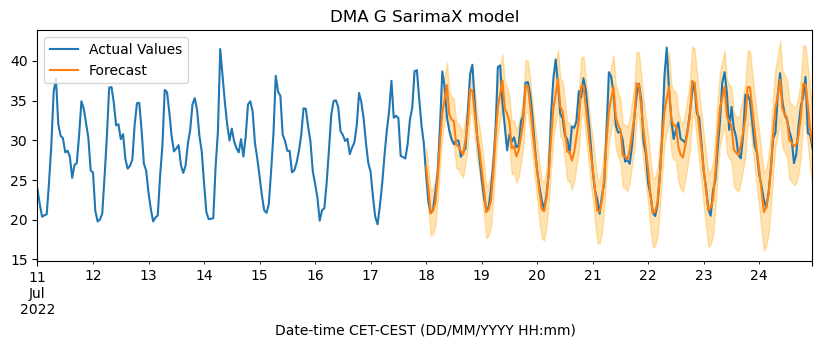

Performance indicators
DMA G Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.56            5.16             1.31           8.04 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.12            10.48             4.38           18.97 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62855D+00    |proj g|=  4.37425D-02


 This problem is unconstrained.



At iterate    5    f=  1.62231D+00    |proj g|=  1.81006D-02

At iterate   10    f=  1.62069D+00    |proj g|=  1.28383D-02

At iterate   15    f=  1.61324D+00    |proj g|=  3.80467D-02

At iterate   20    f=  1.60832D+00    |proj g|=  1.79446D-02

At iterate   25    f=  1.60687D+00    |proj g|=  3.14846D-02

At iterate   30    f=  1.60406D+00    |proj g|=  6.21262D-02

At iterate   35    f=  1.60339D+00    |proj g|=  1.79234D-02

At iterate   40    f=  1.60327D+00    |proj g|=  1.02100D-02

At iterate   45    f=  1.60326D+00    |proj g|=  4.30617D-03

At iterate   50    f=  1.60322D+00    |proj g|=  1.20429D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

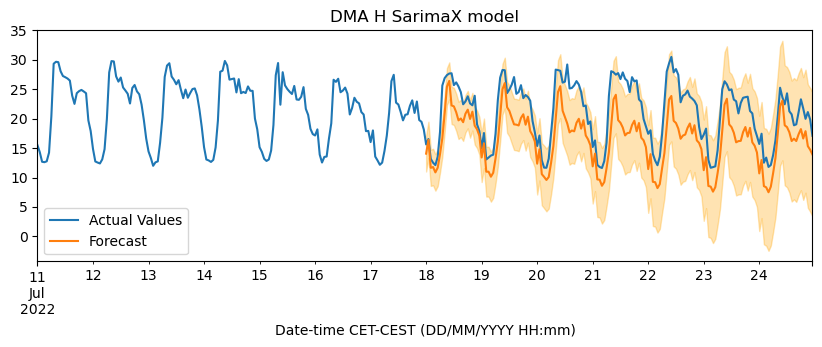

Performance indicators
DMA H Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.97            8.96             4.86           16.79 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.53            9.23             4.50           18.27 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88681D+00    |proj g|=  1.29806D+00


 This problem is unconstrained.



At iterate    5    f=  1.64095D+00    |proj g|=  1.00560D-01

At iterate   10    f=  1.58449D+00    |proj g|=  6.86855D-02

At iterate   15    f=  1.57580D+00    |proj g|=  6.30274D-02

At iterate   20    f=  1.57417D+00    |proj g|=  1.01414D-02

At iterate   25    f=  1.57386D+00    |proj g|=  7.59477D-03

At iterate   30    f=  1.57290D+00    |proj g|=  1.63581D-02

At iterate   35    f=  1.56948D+00    |proj g|=  1.31413D-01

At iterate   40    f=  1.56726D+00    |proj g|=  2.15501D-02

At iterate   45    f=  1.56670D+00    |proj g|=  2.42012D-03

At iterate   50    f=  1.56667D+00    |proj g|=  8.21599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

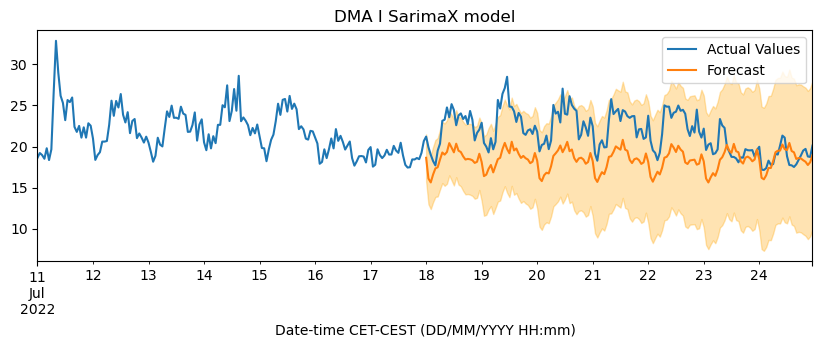

Performance indicators
DMA I Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.68            5.89             3.34           12.90 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.92            3.93             2.14           8.00 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70746D+00    |proj g|=  4.47532D-01


 This problem is unconstrained.



At iterate    5    f=  1.68080D+00    |proj g|=  4.47374D-02

At iterate   10    f=  1.67645D+00    |proj g|=  1.85502D-02

At iterate   15    f=  1.67476D+00    |proj g|=  4.58571D-02

At iterate   20    f=  1.67316D+00    |proj g|=  1.76948D-02

At iterate   25    f=  1.67019D+00    |proj g|=  1.91195D-02

At iterate   30    f=  1.66845D+00    |proj g|=  2.55149D-02

At iterate   35    f=  1.66662D+00    |proj g|=  8.25546D-03

At iterate   40    f=  1.66643D+00    |proj g|=  5.42907D-03

At iterate   45    f=  1.66635D+00    |proj g|=  4.88845D-03

At iterate   50    f=  1.66556D+00    |proj g|=  4.72176D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

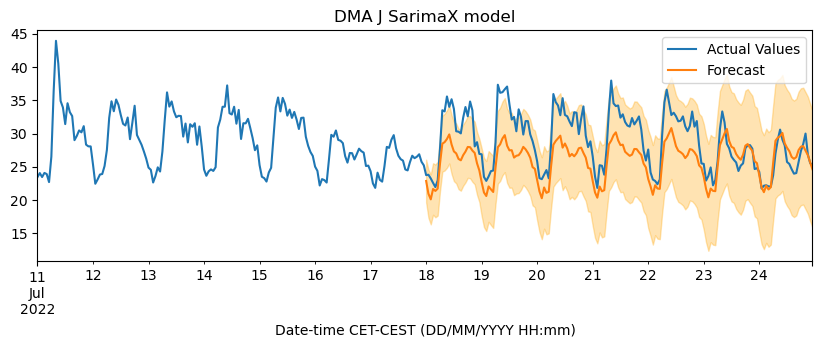

Performance indicators
DMA J Sarima 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.89            6.87             3.22           13.98 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.11            6.84             3.71           14.65 



In [35]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' Sarima 1-Week',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [36]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A Sarima 1-Week,1.709,8.436,1.157,11.302
DMA B Sarima 1-Week,0.845,2.995,0.764,4.604
DMA C Sarima 1-Week,0.723,2.278,0.575,3.576
DMA D Sarima 1-Week,2.518,8.297,2.571,13.387
DMA E Sarima 1-Week,3.672,17.712,3.168,24.552
DMA F Sarima 1-Week,0.988,1.953,1.101,4.042
DMA G Sarima 1-Week,1.562,5.165,1.312,8.039
DMA H Sarima 1-Week,2.966,8.961,4.862,16.789
DMA I Sarima 1-Week,3.676,5.885,3.337,12.899
DMA J Sarima 1-Week,3.888,6.874,3.217,13.979


In [37]:
print(f"{results_df['Total'].sum() :.2f}")

113.17


In [38]:
print(f"{results_df.drop('DMA E Sarima 1-Week')['Total'].sum() :.2f}")

88.62
